<a href="https://colab.research.google.com/github/AIztok/SBB/blob/main/FH_SBB_FEM_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Programm für die Berechnung der Veformungen und Schnittgrößen von 2D Stabmodellen mittels FE**

Das kleine 2D FE Programm setzt sich aus folgenden Teilen zusammen:

1.) Modellierung und Diskretisierung: Das physische Objekt wird in kleinere Einheiten, sogenannte Elemente, unterteilt. Jeder Knotenpunkt eines Elements hat gewisse Freiheitsgrade, die die Bewegung in diesem Punkt beschreiben.

2.) Defintion der Randbedingungen - Auflager.

3.) Definition der Lasten: Externe Kräfte und Momente, die auf die Struktur wirken, werden als Lastvektor definiert. Dies kann sowohl Punktlasten als auch Linienlasten umfassen.

4.) Berechnung der Elementmatrizen: Für jedes Element wird eine Steifigkeitsmatrix aufgestellt, die die Beziehung zwischen den Verschiebungen und den Kräften an den Knotenpunkten beschreibt.

5.) Zusammenbau der globalen Steifigkeitsmatrix: Die Elementmatrizen werden in eine globale Steifigkeitsmatrix integriert, die das gesamte System beschreibt.

6.) Anwendung von Randbedingungen: Hier werden die Bedingungen für Verschiebungen und Kräfte an den Rändern des Modells festgelegt.

7.) Lösung des Gleichungssystems: Mit der globalen Steifigkeitsmatrix, den Randbedingungen und dem Lastvektor wird das Gleichungssystem gelöst, um die unbekannten Verschiebungen an jedem Knotenpunkt zu bestimmen.

8.) Ermittlung der Auflagerreaktionen: Basierend auf den ermittelten Verschiebungen und der globalen Steifigkeitsmatrix werden die Reaktionen an den Auflagern berechnet.

9.) Berechnung der inneren Kräfte: Basierend auf den ermittelten Verschiebungen werden die inneren Kräfte in jedem Element berechnet.

10.) Visualisierung: Die ermittelten Verschiebungen, inneren Kräfte und Auflagerreaktionen werden visualisiert, um eine Vorstellung von der Beanspruchung und Verformung des Modells zu erhalten.

**Importieren der erforderlichen Libraries**

In [ ]:
# Importieren von libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


**1.) Eingabe der Knoten und Stabelemente**

In [ ]:
# Knoten definition
# Nodes (node number: [x, y])
l = 6.00 # length
h = 3.15 # Height
nodes = {1: [0, 0],
         2: [0, h*1],
         3: [l*0.5, h*1],
         4: [l*1, h*1]}

# Elements (element number: [node1, node2, E, A, I])
elements = {1: [1, 2, 32837e03, 0.25, 1.302e-03],
            2: [2, 3, 32837e03, 0.30, 2.250e-03],
            3: [3, 4, 32837e03, 0.30, 2.250e-03]}
display(elements[1])
display(elements[2])
display(elements[3])

[1, 2, 32837000.0, 0.25, 0.001302]

[2, 3, 32837000.0, 0.3, 0.00225]

[3, 4, 32837000.0, 0.3, 0.00225]

**2.) Eingabe der Auflager**

In [ ]:
# Supports (node number: [x_support, y_support, rot_support])
# If = -1 => fixed
# If > 0 => Spring stiffness
supports = {1: [-1, -1, -1],
            2: [0, 0, 0],
            3: [0, 0, 0],
            4: [0, -1, 0]}


**3.) Eingabe der Lasten**

Knotenlasten

In [ ]:
# Loads (node number: [Fx, Fy, Mz])
loads = {1: [0, 0, 0],
         2: [0, 0, 0],
         3: [0, 0, 0],
         4: [0, 0, 0]}


Linienlast (Konstant):


In [ ]:
# Line loads (element number: (wx, wy))
line_loads = {1: (0, -0.25*25), 2: (0, -0.3*25), 3: (0, -0.3*25)}  # Line loads on elements 1 and 2 in global coordinate system

def calculate_equivalent_nodal_loads(wx, wy, L):
    """Calculate equivalent nodal loads for line loads in x and y directions."""
    Wx = wx * L  # Total load in x direction
    Wy = wy * L  # Total load in y direction
    Fx = Wx / 2  # Equivalent point load in x direction
    Fy = Wy / 2  # Equivalent point load in y direction
    M = Wy * L / 12  # Equivalent moment due to y direction load
    return [Fx, Fy, M, -M]  # Return forces and moments for start and end nodes

# Calculate equivalent nodal loads and add to a new dictionary
udl_loads = {}
for e, (wx, wy) in line_loads.items():
    node1, node2 = elements[e][:2]
    L = np.sqrt((nodes[node2][0] - nodes[node1][0])**2 + (nodes[node2][1] - nodes[node1][1])**2)
    Fx1, Fy1, M1, M2 = calculate_equivalent_nodal_loads(wx, wy, L)
    if node1 in udl_loads:
        udl_loads[node1][0] += Fx1
        udl_loads[node1][1] += Fy1
        udl_loads[node1][2] += M1
    else:
        udl_loads[node1] = [Fx1, Fy1, M1]
    if node2 in udl_loads:
        udl_loads[node2][0] += Fx1
        udl_loads[node2][1] += Fy1
        udl_loads[node2][2] += M2
    else:
        udl_loads[node2] = [Fx1, Fy1, M2]

# Combine the udl_loads with the loads dictionary
for node, load in udl_loads.items():
    if node in loads:
        loads[node] = [sum(x) for x in zip(loads[node], load)]
    else:
        loads[node] = load

print(f"Knotenlasten (Punktlasten + Linienlast):")
display(loads)

Knotenlasten (Punktlasten + Linienlast):


{1: [0.0, -9.84375, -5.16796875],
 2: [0.0, -21.09375, -0.45703125],
 3: [0.0, -22.5, 0.0],
 4: [0.0, -11.25, 5.625]}

**4.) Erstellen der lokalen Steifigkeitsmatrix**

Die lokale Steifigkeitsmatrix eines Elements in einem Strukturmodell repräsentiert die Beziehung zwischen den Verschiebungen und den Kräften innerhalb dieses Elements. Sie wird berechnet, indem die physikalischen Eigenschaften des Elements (wie die Elastizitätsmodul E, der Querschnittsfläche A und das Flächenträgheitsmoment I) sowie die Geometrie des Elements (die Länge L und die Ausrichtung) berücksichtigt werden.

In unserem Python-Code definieren wir eine Funktion namens local_beam_element_stiffness, die die lokale Steifigkeitsmatrix für ein gegebenes Element berechnet. Diese Funktion nimmt die Knoten und die Elementinformationen als Eingabe und gibt die lokale Steifigkeitsmatrix als Ausgabe zurück.

Die Funktion berechnet zuerst die Länge des Elements und dann die lokale Steifigkeitsmatrix unter Berücksichtigung der Biegesteifigkeit und der axialen Steifigkeit des Elements. Die resultierende 6x6-Matrix repräsentiert die lokale Steifigkeitsmatrix des Elements in seinem eigenen lokalen Koordinatensystem.

Diese Matrizen sind ein wichtiger Bestandteil der Finite-Elemente-Analyse, da sie verwendet werden, um die globale Steifigkeitsmatrix der gesamten Struktur zu erstellen.

In [ ]:
# Lokale Steifigkeits Matrix
def local_beam_element_stiffness(nodes, element):
    """Calculate local element stiffness matrix for a beam element."""
    node1, node2, E, A, I = element
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    k_local = E * np.array([[A/L, 0, 0, -A/L, 0, 0],
                            [0, 12*I/L**3, 6*I/L**2, 0, -12*I/L**3, 6*I/L**2],
                            [0, 6*I/L**2, 4*I/L, 0, -6*I/L**2, 2*I/L],
                            [-A/L, 0, 0, A/L, 0, 0],
                            [0, -12*I/L**3, -6*I/L**2, 0, 12*I/L**3, -6*I/L**2],
                            [0, 6*I/L**2, 2*I/L, 0, -6*I/L**2, 4*I/L]])
    return k_local

Durch Iteration über alle Elemente in unserem Modell können wir die lokale Steifigkeitsmatrix für jedes Element berechnen und anzeigen.

In [ ]:
# Calculate local stiffness matrices for all elements and display them
for element_number, element in elements.items():
    K_local = local_beam_element_stiffness(nodes, element)
    # nice plot of matrix
    K_local_sp = sp.Matrix(K_local).applyfunc(lambda x: sp.N(x, 3))
    print(f"Local stiffness matrix for element  {element_number}:")
    display(K_local_sp)

Local stiffness matrix for element  1:


Matrix([
[ 2.61e+6,        0,        0, -2.61e+6,        0,        0],
[       0,  1.64e+4,  2.59e+4,        0, -1.64e+4,  2.59e+4],
[       0,  2.59e+4,  5.43e+4,        0, -2.59e+4,  2.71e+4],
[-2.61e+6,        0,        0,  2.61e+6,        0,        0],
[       0, -1.64e+4, -2.59e+4,        0,  1.64e+4, -2.59e+4],
[       0,  2.59e+4,  2.71e+4,        0, -2.59e+4,  5.43e+4]])

Local stiffness matrix for element  2:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Local stiffness matrix for element  3:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

**Erstellen der Transformationsmatrix**

Die Transformationsmatrix wird in der Strukturanalyse verwendet, um die lokalen Steifigkeitsmatrizen der einzelnen Elemente in das globale Koordinatensystem zu übertragen. Dies ist notwendig, weil die lokalen Steifigkeitsmatrizen in den lokalen Koordinatensystemen der einzelnen Elemente definiert sind, während die globale Steifigkeitsmatrix, die das gesamte Strukturmodell repräsentiert, im globalen Koordinatensystem definiert ist.

In unserem Python-Code definieren wir eine Funktion namens calculate_transformation_matrix, die die Transformationsmatrix für ein gegebenes Element berechnet. Diese Funktion nimmt die Knoten und die Elementinformationen als Eingabe und gibt die Transformationsmatrix als Ausgabe zurück.

Die Funktion berechnet zuerst die Länge des Elements und dann die Winkel zwischen der x-Achse des globalen Koordinatensystems und der Linie, die die beiden Knoten des Elements verbindet. Diese Winkel werden dann verwendet, um die Transformationsmatrix zu berechnen.

Die resultierende 6x6-Matrix ist die Transformationsmatrix des Elements. Sie wird verwendet, um die lokale Steifigkeitsmatrix des Elements in das globale Koordinatensystem zu transformieren, indem sie von links und von rechts auf die lokale Steifigkeitsmatrix angewendet wird.

Diese Matrizen sind ein weiterer wichtiger Bestandteil der Finite-Elemente-Analyse, da sie verwendet werden, um die lokalen Steifigkeitsmatrizen in das globale Koordinatensystem zu übertragen.

In [ ]:
def calculate_transformation_matrix(nodes, element):
    """Calculate the transformation matrix for an element."""
    node1, node2 = element[0:2]
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    cos = (x2 - x1) / L
    sin = (y2 - y1) / L
    T = np.zeros((6, 6))
    T[:2, :2] = T[3:5, 3:5] = np.array([[cos, sin], [-sin, cos]])
    T[2, 2] = T[5, 5] = 1
    return T


Durch Iteration über alle Elemente in unserem Modell können wir die Transformationsmatrix für jedes Element berechnen und anzeigen.

In [ ]:
# Calculate transformation matrices for all elements and display them
for element_number, element in elements.items():
    T = calculate_transformation_matrix(nodes, element)
    # nice plot of matrix
    T_sp = sp.Matrix(T).applyfunc(lambda x: sp.N(x, 3))
    print(f"Transformation matrix for element {element_number}:")
    display(T_sp)


Transformation matrix for element 1:


Matrix([
[   0, 1.0,   0,    0,   0,   0],
[-1.0,   0,   0,    0,   0,   0],
[   0,   0, 1.0,    0,   0,   0],
[   0,   0,   0,    0, 1.0,   0],
[   0,   0,   0, -1.0,   0,   0],
[   0,   0,   0,    0,   0, 1.0]])

Transformation matrix for element 2:


Matrix([
[1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0, 1.0]])

Transformation matrix for element 3:


Matrix([
[1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0, 1.0]])

**5.) Globale Steifigkeitsmatrix der Stabelemente**

Die Funktion global_beam_element_stiffness berechnet die globale Steifigkeitsmatrix für ein gegebenes Element in einem Strukturmodell. Die globale Steifigkeitsmatrix repräsentiert die Beziehung zwischen den Verschiebungen und den Kräften innerhalb dieses Elements im globalen Koordinatensystem der gesamten Struktur.

Die Funktion nimmt die Knoten und die Elementinformationen als Eingabe und gibt die globale Steifigkeitsmatrix als Ausgabe zurück. Sie tut dies, indem sie zuerst die lokale Steifigkeitsmatrix des Elements mit der Funktion local_beam_element_stiffness berechnet und dann die Transformationsmatrix des Elements mit der Funktion calculate_transformation_matrix berechnet.

Die lokale Steifigkeitsmatrix wird dann in das globale Koordinatensystem transformiert, indem sie mit der transponierten Transformationsmatrix von links und der Transformationsmatrix von rechts multipliziert wird. Das Ergebnis dieser Operation ist die globale Steifigkeitsmatrix des Elements.

Diese Matrizen sind ein entscheidender Bestandteil der Finite-Elemente-Analyse, da sie verwendet werden, um die globale Steifigkeitsmatrix der gesamten Struktur zu erstellen.

In [ ]:
def global_beam_element_stiffness(nodes, element):
    """Calculate global element stiffness matrix for a beam element."""
    k_local = local_beam_element_stiffness(nodes, element)
    T = calculate_transformation_matrix(nodes, element)
    k_global = T.T @ k_local @ T
    return k_global


Durch Iteration über alle Elemente in unserem Modell können wir die globale Steifigkeitsmatrix für jedes Element berechnen und anzeigen.

In [ ]:
# Calculate global stiffness matrices for all elements and display them
for element_number, element in elements.items():
    K_global = global_beam_element_stiffness(nodes, element)
    # nice plot of matrix
    K_global_sp = sp.Matrix(K_global).applyfunc(lambda x: sp.N(x, 3))
    print(f"Global stiffness matrix for element{element_number}:")
    display(K_global_sp)

Global stiffness matrix for element1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4]])

Global stiffness matrix for element2:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix for element3:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Die Funktion assemble_global_stiffness erstellt die globale Steifigkeitsmatrix für die gesamte Struktur aus den globalen Steifigkeitsmatrizen der einzelnen Elemente.

Zuerst berechnet die Funktion die Anzahl der Freiheitsgrade der gesamten Struktur, die gleich der Anzahl der Knoten multipliziert mit 3 ist (da es in einem 2D-Balkenproblem 3 Freiheitsgrade pro Knoten gibt). Dann initialisiert sie die globale Steifigkeitsmatrix als Nullmatrix der entsprechenden Größe.

Die Funktion iteriert dann über alle Elemente in der Struktur. Für jedes Element berechnet sie die globale Steifigkeitsmatrix mit der Funktion global_beam_element_stiffness und zeigt diese an. Dann bestimmt sie die Freiheitsgrade, die mit den beiden Knoten des Elements verbunden sind.

In einer verschachtelten Schleife fügt die Funktion dann die Einträge der globalen Steifigkeitsmatrix des Elements zur entsprechenden Position in der globalen Steifigkeitsmatrix der gesamten Struktur hinzu. Nach dem Hinzufügen jedes Elements zeigt die Funktion die aktualisierte globale Steifigkeitsmatrix an.

Am Ende gibt die Funktion die zusammengesetzte globale Steifigkeitsmatrix zurück. Diese Matrix repräsentiert die Beziehung zwischen den Verschiebungen und den Kräften in der gesamten Struktur und ist ein zentraler Bestandteil der Finite-Elemente-Analyse.

In [ ]:
def assemble_global_stiffness(nodes, elements):
    """Assemble the global stiffness matrix from the element stiffness matrices."""
    dof = len(nodes) * 3  # Degrees of freedom (3 per node for 2D beam)
    K = np.zeros((dof, dof))
    for element, properties in elements.items():
        k_global = global_beam_element_stiffness(nodes, properties)
        # nice plot of matrix
        k_global_sp = sp.Matrix(k_global).applyfunc(lambda x: sp.N(x, 3))
        print(f"Global stiffness matrix for element {element}:")
        display(k_global_sp)
        node1, node2 = properties[:2]
        # DOFs related to the element (6 for each beam element)
        dofs = [node1*3-3, node1*3-2, node1*3-1, node2*3-3, node2*3-2, node2*3-1]
        for i in range(6):
            for j in range(6):
                K[dofs[i], dofs[j]] += k_global[i, j]
        K_sp = sp.Matrix(K).applyfunc(lambda x: sp.N(x, 3))
        print(f"Global stiffness matrix after adding element {element}:")
        display(K_sp)
    return K


In [ ]:
# Calculate the global stiffness matrix
K_global = assemble_global_stiffness(nodes, elements)

Global stiffness matrix for element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4]])

Global stiffness matrix after adding element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4, 0, 0, 0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4, 0, 0, 0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4, 0, 0, 0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0]])

Global stiffness matrix for element 2:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 2:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4, 0, 0, 0],
[       0,        0,        0, -3.28e+6,        0,        0,  3.28e+6,        0,        0, 0, 0, 0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4, 0, 0, 0],
[       0,        0,        0,        0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4, 0, 0, 0],
[       0,        0,        0,        0,        0,        0,        0,        0,  

Global stiffness matrix for element 3:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 3:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0,        0,        0,        0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0,        0,        0,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0,        0,        0,        0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0,        0,        0,        0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4,        0,        0,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4,        0,        0,        0],
[       0,        0,        0, -3.28e+6,        0,        0,  6.57e+6,        0,        0, -3.28e+6,        0,        0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  6.57e+4,        0,        0, -3.28e+4,  4.93e+4],
[       0,     

Die Funktion apply_boundary_conditions wendet die Randbedingungen auf die Steifigkeitsmatrix und den Lastvektor an.

Zuerst berechnet die Funktion die Anzahl der Freiheitsgrade der gesamten Struktur, die gleich der Anzahl der Knoten multipliziert mit 3 ist (da es in einem 2D-Balkenproblem 3 Freiheitsgrade pro Knoten gibt). Dann initialisiert sie den Lastvektor als Nullvektor der entsprechenden Größe.

Die Funktion iteriert dann über alle Knoten und Lasten in der Struktur. Für jeden Knoten und jede Last fügt sie die Lastwerte zum entsprechenden Eintrag im Lastvektor hinzu.

Danach iteriert die Funktion über alle Knoten und Stützen in der Struktur. Für jeden Knoten und jede Stütze überprüft sie, ob der Freiheitsgrad fest ist (d.h., ob er den Wert -1 hat). Wenn ja, setzt sie die entsprechende Zeile und Spalte in der Steifigkeitsmatrix auf Null, setzt den Diagonaleintrag auf 1 und setzt den entsprechenden Eintrag im Lastvektor auf Null. Dies stellt sicher, dass die Randbedingung, dass die Verschiebung an diesem Freiheitsgrad Null ist, erfüllt ist.

Wenn der Freiheitsgrad eine Federstütze hat (d.h., wenn er einen Wert größer als Null hat), fügt sie die Federsteifigkeit zum Diagonaleintrag in der Steifigkeitsmatrix hinzu. Dies stellt die zusätzliche Steifigkeit dar, die die Federstütze der Struktur verleiht.

Am Ende gibt die Funktion die modifizierte Steifigkeitsmatrix und den Lastvektor zurück. Diese können dann zur Lösung des Systems von Gleichungen verwendet werden, um die Verschiebungen an jedem Freiheitsgrad zu finden.

In [ ]:
def apply_boundary_conditions(K, supports, loads):
    """Apply boundary conditions to the stiffness matrix and load vector."""
    dof = len(nodes) * 3  # Degrees of freedom (3 per node for 2D beam)
    F = np.zeros(dof)
    for node, load in loads.items():
        F[node*3-3:node*3] = load  # Apply loads
    for node, support in supports.items():
        for i in range(3):
            if support[i] == -1:  # If the DOF is fixed
                K[node*3-3+i, :] = K[:, node*3-3+i] = 0  # Zero out the corresponding row and column in K
                K[node*3-3+i, node*3-3+i] = 1  # Set the diagonal to 1
                F[node*3-3+i] = 0  # Zero out the corresponding entry in F
            elif support[i] > 0:  # If there is a spring support
                K[node*3-3+i, node*3-3+i] += support[i]  # Add spring stiffness to the diagonal
    return K, F


**6.) Ermittlung der Verschiebungen**
Die Funktion calculate_displacements löst das Gleichungssystem K * d = F, um die Verschiebungen d zu finden. Es wird die Funktion np.linalg.solve von NumPy, die eine lineare Matrixgleichung löst, verwendet.

In [ ]:
def calculate_displacements(K, F):
    """Solve the system of equations to find the displacements."""
    d = np.linalg.solve(K, F)
    return d

In [ ]:
K = assemble_global_stiffness(nodes, elements)
K, F = apply_boundary_conditions(K, supports, loads)
d = calculate_displacements(K, F)
# nice plot of matrix
K_sp = sp.Matrix(K).applyfunc(lambda x: sp.N(x, 3))
print(f"Global stiffness matrix with boundary conditions considered:")
display(K_sp)
print(f"Load vector:")
display(sp.Matrix([sp.N(x, 3) for x in F]))  # plot load vector
print(f"Displacement vector in [m], [rad]:")
display(sp.Matrix([sp.N(x, 3) for x in d]))  # plot calculated displacement vector in [m], [rad]
print(f"Displacement vector in [mm], [mrad]:")
display(sp.Matrix([sp.N(x, 3) for x in d*1000])) # plot calculated displacement vector in [mm], [mrad]



Global stiffness matrix for element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4]])

Global stiffness matrix after adding element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4, 0, 0, 0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4, 0, 0, 0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4, 0, 0, 0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0]])

Global stiffness matrix for element 2:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 2:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4, 0, 0, 0],
[       0,        0,        0, -3.28e+6,        0,        0,  3.28e+6,        0,        0, 0, 0, 0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4, 0, 0, 0],
[       0,        0,        0,        0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4, 0, 0, 0],
[       0,        0,        0,        0,        0,        0,        0,        0,  

Global stiffness matrix for element 3:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 3:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0,        0,        0,        0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0,        0,        0,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0,        0,        0,        0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0,        0,        0,        0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4,        0,        0,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4,        0,        0,        0],
[       0,        0,        0, -3.28e+6,        0,        0,  6.57e+6,        0,        0, -3.28e+6,        0,        0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  6.57e+4,        0,        0, -3.28e+4,  4.93e+4],
[       0,     

Global stiffness matrix with boundary conditions considered:


Matrix([
[1.0,   0,   0,        0,        0,        0,        0,        0,       0,        0,   0,       0],
[  0, 1.0,   0,        0,        0,        0,        0,        0,       0,        0,   0,       0],
[  0,   0, 1.0,        0,        0,        0,        0,        0,       0,        0,   0,       0],
[  0,   0,   0,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,       0,        0,   0,       0],
[  0,   0,   0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4, 4.93e+4,        0,   0,       0],
[  0,   0,   0,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4, 4.93e+4,        0,   0,       0],
[  0,   0,   0, -3.28e+6,        0,        0,  6.57e+6,        0,       0, -3.28e+6,   0,       0],
[  0,   0,   0,        0, -3.28e+4, -4.93e+4,        0,  6.57e+4,       0,        0,   0, 4.93e+4],
[  0,   0,   0,        0,  4.93e+4,  4.93e+4,        0,        0, 1.97e+5,        0,   0, 4.93e+4],
[  0,   0,   0,        0,        0,        0, -3.28e+6,        0,       0,  3.28e+6,   0,  

Load vector:


Matrix([
[     0],
[     0],
[     0],
[     0],
[ -21.1],
[-0.457],
[     0],
[ -22.5],
[     0],
[     0],
[     0],
[  5.63]])

Displacement vector in [m], [rad]:


Matrix([
[        0],
[        0],
[        0],
[ 0.000889],
[ -1.32e-5],
[-0.000564],
[ 0.000889],
[ -0.00133],
[ -4.12e-5],
[ 0.000889],
[        0],
[ 0.000742]])

Displacement vector in [mm], [mrad]:


Matrix([
[      0],
[      0],
[      0],
[  0.889],
[-0.0132],
[ -0.564],
[  0.889],
[  -1.33],
[-0.0412],
[  0.889],
[      0],
[  0.742]])

In [ ]:
def plot_structure(nodes, elements, displacements=None, factor=1):
    """Plot the structure with optional exaggerated displacements."""
    fig, ax = plt.subplots()

    # If displacements are provided, add them to the node coordinates
    if displacements is not None:
        nodes = nodes.copy()  # Don't want to change the original nodes dict
        for node, coords in nodes.items():
            nodes[node] = [coords[0] + factor*displacements[node*3-3],
                           coords[1] + factor*displacements[node*3-2]]

    # Plot the nodes
    for node, coords in nodes.items():
        ax.plot(coords[0], coords[1], 'ko')
        ax.text(coords[0], coords[1], f'Node {node}')

    # Plot the elements
    for element, properties in elements.items():
        node1, node2 = properties[:2]
        ax.plot([nodes[node1][0], nodes[node2][0]],
                [nodes[node1][1], nodes[node2][1]], 'k-')

    # Equal aspect ratio and labels
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title('Structure Plot')
    plt.grid(True)
    plt.show()


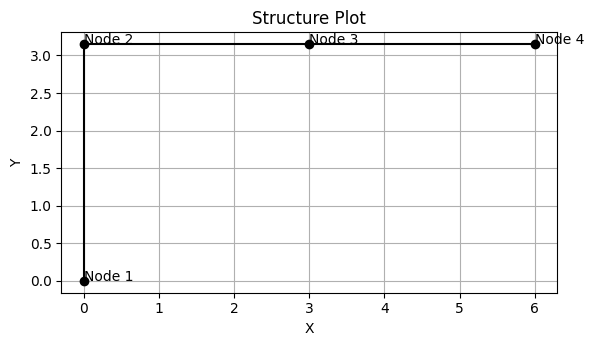

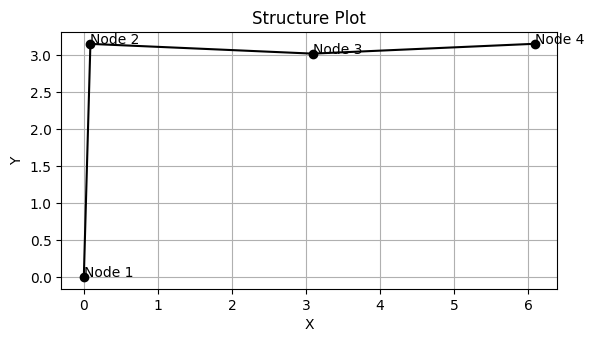

In [ ]:
plot_structure(nodes, elements)
plot_structure(nodes, elements, d, factor=100)

In [ ]:
# Calculate local internal forces
forces = {}
forces_vis = {}  # Dictionary to store modified forces for visualization
for e, element in elements.items():
    # Get global displacements for this element
    i, j = element[0], element[1]
    d_global = np.concatenate((d[3*i-3:3*i], d[3*j-3:3*j]))
    # Calculate local displacements
    T = calculate_transformation_matrix(nodes, element)
    d_local = T @ d_global
    # Calculate local internal forces
    K_local = local_beam_element_stiffness(nodes, element)
    f_local = K_local @ d_local
    # Adjust for the element loads if they exist
    if e in line_loads:
        wx, wy = line_loads[e]
        L = np.sqrt((nodes[node2][0] - nodes[node1][0])**2 + (nodes[node2][1] - nodes[node1][1])**2)
        Fx1, Fy1, M1, M2 = calculate_equivalent_nodal_loads(wx, wy, L)
        f_local -= np.array([Fx1, Fy1, M1, Fx1, Fy1, M2])
    forces[e] = f_local
    forces_vis[e] = [-f_local[0], -f_local[1], -f_local[2], f_local[3], f_local[4], f_local[5]]

# Display internal forces for each element
for e, f in forces.items():
    print(f"Internal forces for Element {e}:")
    display(sp.Matrix([sp.N(x, 3) for x in f]))

# Display internal forces for each element
for e, f in forces_vis.items():
    print(f"Internal forces for visualization for Element {e}:")
    display(sp.Matrix([sp.N(x, 3) for x in f]))


Internal forces for Element 1:


Matrix([
[ 34.5],
[ 9.38],
[ 12.3],
[-34.5],
[ 9.38],
[-12.3]])

Internal forces for Element 2:


Matrix([
[    0],
[ 24.6],
[ 12.8],
[    0],
[-2.14],
[ 27.3]])

Internal forces for Element 3:


Matrix([
[        0],
[     2.14],
[    -27.3],
[        0],
[     20.4],
[-1.42e-14]])

Internal forces for visualization for Element 1:


Matrix([
[-34.5],
[-9.38],
[-12.3],
[-34.5],
[ 9.38],
[-12.3]])

Internal forces for visualization for Element 2:


Matrix([
[    0],
[-24.6],
[-12.8],
[    0],
[-2.14],
[ 27.3]])

Internal forces for visualization for Element 3:


Matrix([
[        0],
[    -2.14],
[     27.3],
[        0],
[     20.4],
[-1.42e-14]])

**Graphische Ausgabe der Schnittgrößen pro Element**
Dieser Code erstellt separate Diagramme für die Axialkraft, Scherkraft und das Biegemoment jedes Elements. Für jedes Element wird ein Satz von drei Diagrammen erstellt. Die x-Achse stellt die Position entlang des Balkenelements dar, während die y-Achse die Größe der jeweiligen internen Kraft darstellt.

Die Funktion linspace wird verwendet, um eine Reihe von x-Koordinaten zu erzeugen, die von 0 bis 1 reichen. Diese repräsentieren die Positionen entlang des Balkenelements, an denen die internen Kräfte berechnet werden.

Die internen Kräfte werden als lineare Variationen entlang des Balkenelements angenommen. Die Funktionen F_axial = np.linspace(f[0], f[3], 100), F_shear = np.linspace(f[1], f[4], 100) und M_bending = np.linspace(f[2], f[5], 100) erzeugen daher eine Reihe von Werten für die Axialkraft, Scherkraft und das Biegemoment, die von den Werten an den Enden des Balkenelements linear variieren.

Die Funktion plt.plot(x, F_axial) zeichnet dann die Axialkraft als Funktion der Position entlang des Balkenelements. Ähnliche Funktionen werden verwendet, um die Scherkraft und das Biegemoment zu zeichnen.

Die Funktion plt.grid(True) wird verwendet, um Gitterlinien zu den Diagrammen hinzuzufügen, was das Ablesen der Diagramme erleichtert.

Schließlich wird die Funktion plt.show() verwendet, um die erstellten Diagramme anzuzeigen.

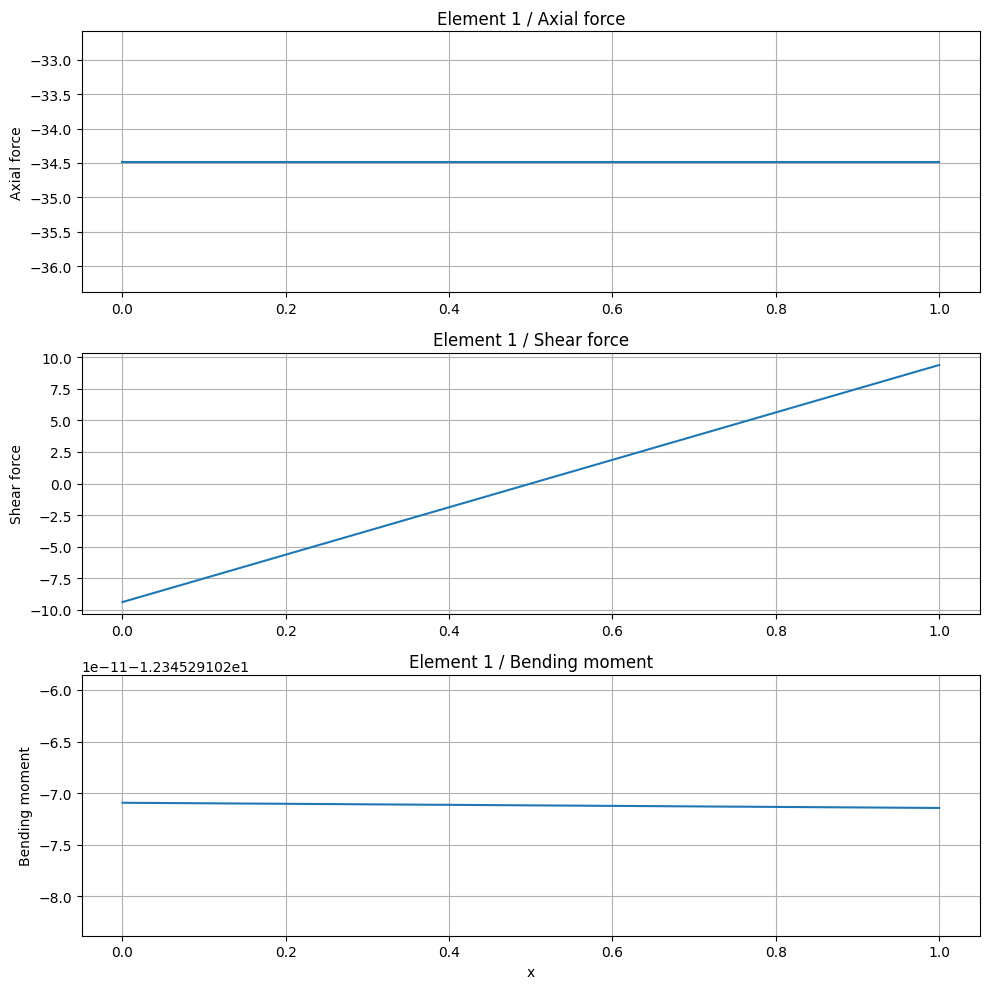

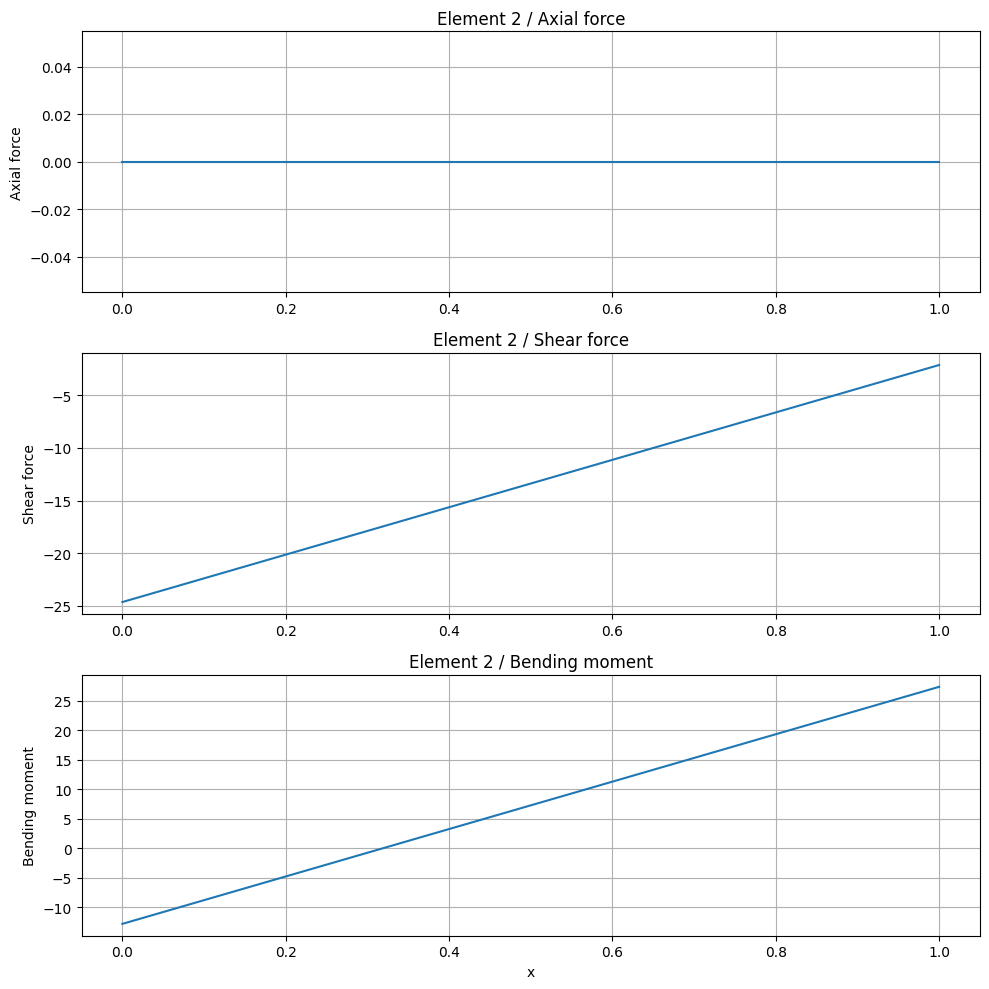

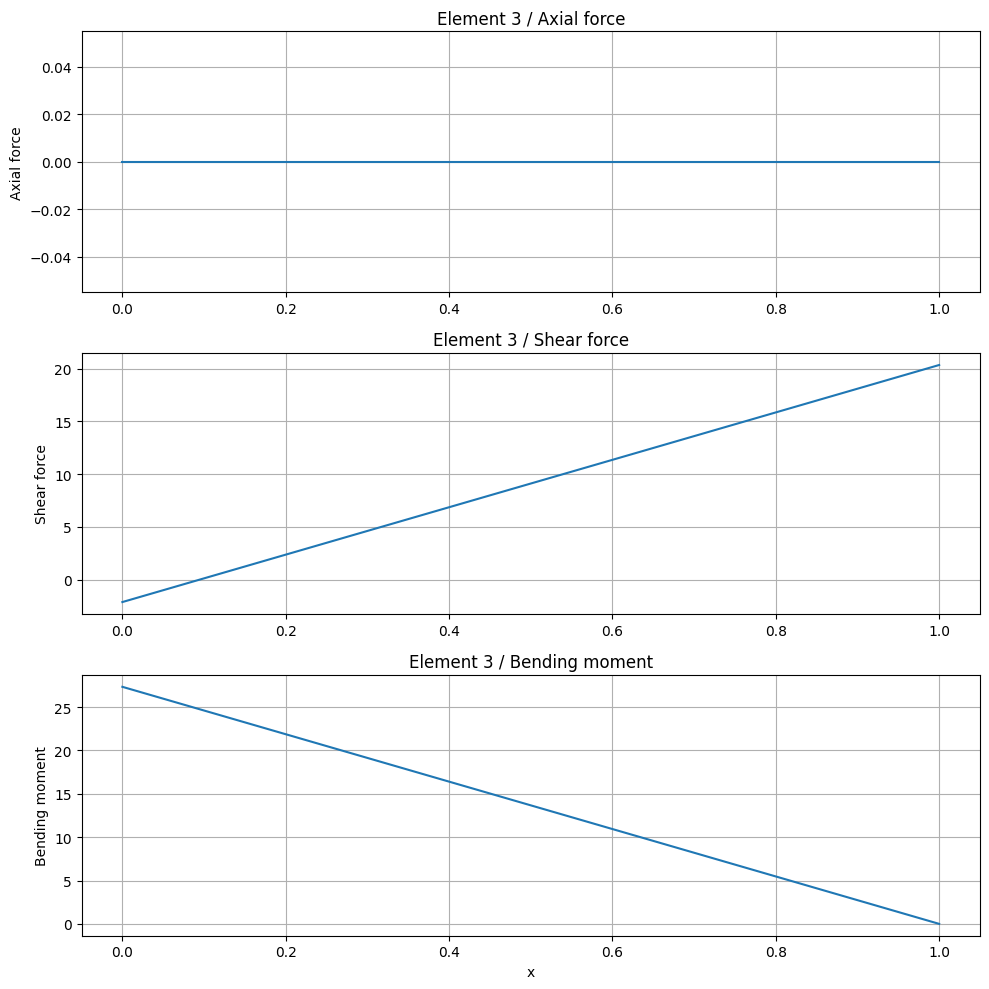

In [ ]:
for e, f in forces_vis.items():
    x = np.linspace(0, 1, 100)  # x-coordinates along the beam

    # Assuming linear variation of the forces
    F_axial = np.linspace(f[0], f[3], 100)
    F_shear = np.linspace(f[1], f[4], 100)
    M_bending = np.linspace(f[2], f[5], 100)

    plt.figure(figsize=(10, 10))

    plt.subplot(311)
    plt.plot(x, F_axial)
    plt.ylabel('Axial force')
    plt.title(f'Element {e} / Axial force')
    plt.grid(True)

    plt.subplot(312)
    plt.plot(x, F_shear)
    plt.ylabel('Shear force')
    plt.title(f'Element {e} / Shear force')
    plt.grid(True)

    plt.subplot(313)
    plt.plot(x, M_bending)
    plt.ylabel('Bending moment')
    plt.title(f'Element {e} / Bending moment')
    plt.grid(True)

    plt.xlabel('x')
    plt.tight_layout()
    plt.show()



**Ermittlung der Lagerreaktionen**
In diesem Code wird die Funktion calculate_reaction_forces definiert, die die Reaktionskräfte in einem Strukturmodell berechnet. Diese Funktion nimmt die globale Steifigkeitsmatrix K und den Verschiebungsvektor d als Eingabe und berechnet die resultierenden Kräfte F durch Multiplikation von K und d.

Anschließend wird die globale Steifigkeitsmatrix K erstellt, indem die Funktion assemble_global_stiffness aufgerufen wird, die die Steifigkeitsmatrizen aller Elemente in der Struktur zusammenfügt.

Die Reaktionskräfte F werden dann durch Aufruf der Funktion calculate_reaction_forces mit K und d als Argumenten berechnet.

Schließlich wird für jeden Knoten in der Struktur, der eine Unterstützung hat (d.h., an dem Randbedingungen angewendet werden), die resultierende Reaktionskraft in x-, y- und z-Richtung ausgegeben. Diese Kräfte sind im globalen Koordinatensystem.

In [ ]:
def calculate_reaction_forces(K, d, loads):
    """Calculate the reaction forces."""
    dof = len(nodes) * 3  # Degrees of freedom (3 per node for 2D beam)
    F_external = np.zeros(dof)
    for node, load in loads.items():
        F_external[node*3-3:node*3] = load  # Apply loads
    F_internal = K @ d
    F_reaction = F_external - F_internal
    return F_reaction

# Assemble the global stiffness matrix without applying boundary conditions
K = assemble_global_stiffness(nodes, elements)

# Calculate the reaction forces
F = calculate_reaction_forces(K, d, loads)

# Now, F contains the reaction forces at the degrees of freedom where boundary conditions are applied.
# You can print these forces as follows:

for node, support in supports.items():
    if -1 in support:  # If the node is supported
        print(f"Reaction forces at Node {node}:")
        print(f"Fx = {F[node*3-3]:.3f}")
        print(f"Fy = {F[node*3-2]:.3f}")
        print(f"Mz = {F[node*3-1]:.3f}")


Global stiffness matrix for element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4]])

Global stiffness matrix after adding element 1:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4, 0, 0, 0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4, 0, 0, 0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,  1.64e+4,        0,  2.59e+4, 0, 0, 0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.61e+6,        0, 0, 0, 0, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,        0,  5.43e+4, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0],
[       0,        0,        0,        0,        0,        0, 0, 0, 0, 0, 0, 0]])

Global stiffness matrix for element 2:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 2:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0, 0, 0, 0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0, 0, 0, 0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0, 0, 0, 0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0, 0, 0, 0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4, 0, 0, 0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4, 0, 0, 0],
[       0,        0,        0, -3.28e+6,        0,        0,  3.28e+6,        0,        0, 0, 0, 0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4, 0, 0, 0],
[       0,        0,        0,        0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4, 0, 0, 0],
[       0,        0,        0,        0,        0,        0,        0,        0,  

Global stiffness matrix for element 3:


Matrix([
[ 3.28e+6,        0,        0, -3.28e+6,        0,        0],
[       0,  3.28e+4,  4.93e+4,        0, -3.28e+4,  4.93e+4],
[       0,  4.93e+4,  9.85e+4,        0, -4.93e+4,  4.93e+4],
[-3.28e+6,        0,        0,  3.28e+6,        0,        0],
[       0, -3.28e+4, -4.93e+4,        0,  3.28e+4, -4.93e+4],
[       0,  4.93e+4,  4.93e+4,        0, -4.93e+4,  9.85e+4]])

Global stiffness matrix after adding element 3:


Matrix([
[ 1.64e+4,        0, -2.59e+4, -1.64e+4,        0, -2.59e+4,        0,        0,        0,        0,        0,        0],
[       0,  2.61e+6,        0,        0, -2.61e+6,        0,        0,        0,        0,        0,        0,        0],
[-2.59e+4,        0,  5.43e+4,  2.59e+4,        0,  2.71e+4,        0,        0,        0,        0,        0,        0],
[-1.64e+4,        0,  2.59e+4,   3.3e+6,        0,  2.59e+4, -3.28e+6,        0,        0,        0,        0,        0],
[       0, -2.61e+6,        0,        0,  2.64e+6,  4.93e+4,        0, -3.28e+4,  4.93e+4,        0,        0,        0],
[-2.59e+4,        0,  2.71e+4,  2.59e+4,  4.93e+4,  1.53e+5,        0, -4.93e+4,  4.93e+4,        0,        0,        0],
[       0,        0,        0, -3.28e+6,        0,        0,  6.57e+6,        0,        0, -3.28e+6,        0,        0],
[       0,        0,        0,        0, -3.28e+4, -4.93e+4,        0,  6.57e+4,        0,        0, -3.28e+4,  4.93e+4],
[       0,     

Reaction forces at Node 1:
Fx = -0.000
Fy = -44.325
Mz = -12.826
Reaction forces at Node 4:
Fx = 0.000
Fy = -20.362
Mz = 0.000
